# CS579: Lecture 06  
** Graph Partitioning **

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

<br><br><br><br><br><br>

Recall the network from last lecture:

![network](network.png)

We identified edge $(B,D)$ as a good candidate to remove to create two clusters based on *betweenness*.

Today we'll discuss an alternative clustering approach based on *graph cuts.*

- A **cut** $C=(S,T)$ partitions the vertices $V$ of a graph into two subsets $S$ and $T$.
- The **cut-set** of $C$ is the set of edges that have one endpoint in $S$ and the other in $T$


**What makes a good cut?**

![partition](partition.png)

The cut-set $\{(H,C)\}$ is smaller than the set $\{(B,D), (C,G)\}$. 

Why might we not like cut $\{(H,C)\}$?

A good cut is:

- small
- balanced

How to quantify these?
<br><br><br>

$Vol(S)$: **volume** of a set of $S$ nodes is the number of edges with at least one end in $S$.

![partition](partition.png)

$Vol(\{A,B,C\})=6$

Let $Cut(S,T)$ be the number of edges in cut-set of cut $C=(S,T)$ (the cut **size**).

The **normalized cut value** for $(S,T)$ is:

$$NCV(S,T) = \frac{Cut(S,T)}{Vol(S)} + \frac{Cut(S,T)}{Vol(T)}$$

![partition](partition.png)

Example:

Consider the cut where $S=\{H\}$ and $T=\{A,B,C,D,E,F,G\}$.

- $Cut(S,T) = 1$
- $Vol(S) = 1$
- $Vol(T) = 11$
- $NCV(S,T) = \frac{1}{1} + \frac{1}{11} = 1.09$


![partition](partition.png)

Example:

Consider the cut where $S=\{A,B,C,H\}$ and $T=\{D,E,F,G\}$.

- $Cut(S,T) = 2$
- $Vol(S) = 6$
- $Vol(T) = 7$
- $NCV(S,T) = \frac{2}{6} + \frac{2}{7} = 0.62$

So, if one part of the cut has a small volume, the normalized cut value will be large.

**Problem:** How do we identify the cut with the smallest normalized cut value?

<br><br><br><br>
Like most good things, it is NP-hard.

**Linear algebra to the rescue!**

Below, we describe a way to approximate the optimal cuts using eigenvalue decomposition.

** Representing Graphs with Matrices **

- **Adjacency matrix** $A$:  &nbsp;&nbsp;&nbsp; $A[i, j] = 1$ iff there is an edge from $i$ to $j$.
- **Degree matrix** $D$:  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $D[i, i] = deg(i)$, else 0



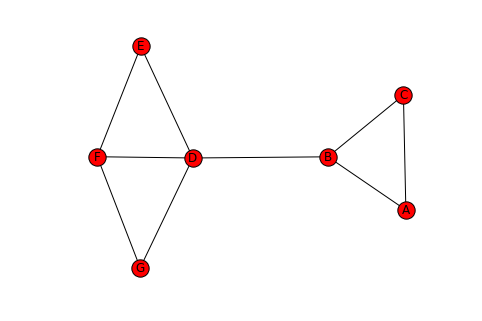

In [30]:
%matplotlib inline 
import matplotlib.pyplot as plt
import networkx as nx
graph = nx.Graph()
graph.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('E', 'F'), ('G', 'F')])
nx.draw(graph, with_labels=True)

In [3]:
# Print the adjacency matrix.
def adjacency_matrix(graph):
    return nx.adjacency_matrix(graph, sorted(graph.nodes()))

adjacency = adjacency_matrix(graph)
print('Adjacency matrix:\n', adjacency.todense())

Adjacency matrix:
 [[0 1 1 0 0 0 0]
 [1 0 1 1 0 0 0]
 [1 1 0 0 0 0 0]
 [0 1 0 0 1 1 1]
 [0 0 0 1 0 1 0]
 [0 0 0 1 1 0 1]
 [0 0 0 1 0 1 0]]


** What data structure should we use to store the adjacency matrix? **

<br><br><br><br><br>

- Naive 2d array: $O(V^2)$ space, for $V$ vertices.
- But, graphs are sparse ($E << V^2$), for $E$ edges.
- Instead, only store non-zeros

E.g., list of tuples `[(0,1), (0,2), (1,2), ...]`
  - Space = $O(E)$
  - We'll look at these *sparse matrices* in more detail later.

In [4]:
# Print the degree matrix.
import numpy as np

def degree_matrix(graph):
    degrees = graph.degree().items()
    degrees = sorted(degrees, key=lambda x: x[0])
    degrees = [d[1] for d in degrees]
    return np.diag(degrees)

degree = degree_matrix(graph)
print('Degree matrix:\n', degree)

Degree matrix:
 [[2 0 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 2]]


**Laplacian matrix** $L = D - A$

- **Adjacency matrix** $A$:  &nbsp;&nbsp;&nbsp; $A[i, j] = 1$ iff there is an edge from $i$ to $j$.
- **Degree matrix** $D$:  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $D[i, i] = deg(i)$, else 0



In [5]:
def laplacian_matrix(graph):
    return degree_matrix(graph) - adjacency_matrix(graph)

laplacian = laplacian_matrix(graph)
print('Laplacian matrix:\n', laplacian)

Laplacian matrix:
 [[ 2 -1 -1  0  0  0  0]
 [-1  3 -1 -1  0  0  0]
 [-1 -1  2  0  0  0  0]
 [ 0 -1  0  4 -1 -1 -1]
 [ 0  0  0 -1  2 -1  0]
 [ 0  0  0 -1 -1  3 -1]
 [ 0  0  0 -1  0 -1  2]]


**Properties of Laplacian matrix:**
- rows sum to 0; columns sum to 0
- symmetric
- positive-semidefinite &nbsp;&nbsp; ($z^TLz \ge 0$ &nbsp;&nbsp;&nbsp; $\forall $ nonzero $z$)


** Recall that a matrix is a type of linear transformation.**

For an arbitrary vector $v$, what does $Lv$ mean?

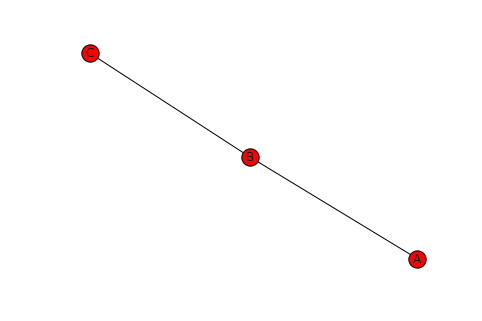

In [6]:
# For a smaller graph.
graph2 = nx.Graph()
graph2.add_edges_from([('A', 'B'), ('B', 'C')])
nx.draw(graph2, with_labels=True)

In [7]:
laplacian2 = laplacian_matrix(graph2)
print(laplacian2)

[[ 1 -1  0]
 [-1  2 -1]
 [ 0 -1  1]]


Let $v$ be a map from nodes to real values. 

E.g., $v = \{f(A), f(B), f(C)\}$

Then, $Lv$ is:

$$ \begin{pmatrix}
  1 & -1 & 0 \\
  -1 & 2 & -1 \\
  0 & -1 & 1
 \end{pmatrix}
 \begin{pmatrix}
 f(A)\\
 f(B)\\
 f(C)\\
 \end{pmatrix}
 =
 \begin{pmatrix}
  f(A) - f(B)\\
  -f(A) + 2f(B) - f(C)\\
  -f(B) + f(C)
 \end{pmatrix}$$
 
More generally:

$Lv[i]= [deg(i) ∗ (f(i) − $average of $f$ on neighbors of $i)]$


In [8]:
print(laplacian2.dot([1,2,3]))

[[-1  0  1]]


In [9]:
print(laplacian2.dot([3,2,1]))

[[ 1  0 -1]]


** Review of Linear Algebra**

A vector $\mathbf{v}$ of dimension $n$ is an **eigenvector **of a square $(n×n)$ matrix $A$ if and only if 
$$ A \mathbf{v} = \lambda \mathbf{v}  $$

where $\lambda$ is a scalar, called an **eigenvalue**.

In otherwords, $\mathbf{v}$ is just a linear scaling of $A$.

<br><br><br><br>
Assume $A$ has $n$ linearly independent eigenvectors, $\{\mathbf{v}_1 \ldots \mathbf{v}_n\}$. 

Let $V$ be a square matrix where column $i$ is $\mathbf{v}_i$.

Then A can be factorized as
$A=V \Lambda V^{-1}  $ where

$\Lambda$ is a diagonal matrix of eigenvalues: $\Lambda[i, i]=\lambda_i$.

![eval](http://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Eigenvalue_equation.svg/375px-Eigenvalue_equation.svg.png)

[source](http://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)

**What happens when we compute the eigenvalue decomposition of the Laplacian $L$**?

- Smallest eigenvalue $\lambda_0=0$
  - Corresponding eigenvector $\mathbf{v}_0 = \mathbf{1}$

In [10]:
print(laplacian2.dot([1,1,1]))

[[0 0 0]]


**What about second eigenvector?**


In [11]:
# Library to compute eigenvectors:
from numpy.linalg import eigh
help(eigh)

Help on function eigh in module numpy.linalg.linalg:

eigh(a, UPLO='L')
    Return the eigenvalues and eigenvectors of a Hermitian or symmetric matrix.
    
    Returns two objects, a 1-D array containing the eigenvalues of `a`, and
    a 2-D square array or matrix (depending on the input type) of the
    corresponding eigenvectors (in columns).
    
    Parameters
    ----------
    a : (..., M, M) array
        Hermitian/Symmetric matrices whose eigenvalues and
        eigenvectors are to be computed.
    UPLO : {'L', 'U'}, optional
        Specifies whether the calculation is done with the lower triangular
        part of `a` ('L', default) or the upper triangular part ('U').
    
    Returns
    -------
    w : (..., M) ndarray
        The eigenvalues in ascending order, each repeated according to
        its multiplicity.
    v : {(..., M, M) ndarray, (..., M, M) matrix}
        The column ``v[:, i]`` is the normalized eigenvector corresponding
        to the eigenvalue ``w[i]``. 

In [37]:
eig_vals, eig_vectors = eigh(laplacian)
print('eigen values\n%s' % str(eig_vals))
print('eigen vectors\n%s' % str(eig_vectors))

eigen values
[ -1.43917928e-15   3.98320868e-01   2.00000000e+00   3.00000000e+00
   3.33987689e+00   4.00000000e+00   5.26180225e+00]
eigen vectors
[[ -3.77964473e-01   4.92886500e-01   7.61771655e-17  -7.07106781e-01
   -3.20722630e-01  -8.40213177e-17  -1.06502348e-01]
 [ -3.77964473e-01   2.96559521e-01   1.92527950e-16   1.88737914e-15
    7.50451469e-01   6.04607112e-16   4.53891948e-01]
 [ -3.77964473e-01   4.92886500e-01  -1.92527950e-16   7.07106781e-01
   -3.20722630e-01  -4.36564477e-16  -1.06502348e-01]
 [ -3.77964473e-01  -2.14220282e-01   4.01736195e-17   9.99200722e-16
    3.86384151e-01   2.68521841e-16  -8.13609130e-01]
 [ -3.77964473e-01  -3.56037413e-01   7.07106781e-01  -3.88578059e-16
   -1.65130120e-01  -4.08248290e-01   1.90907293e-01]
 [ -3.77964473e-01  -3.56037413e-01   7.02923822e-17  -3.33066907e-16
   -1.65130120e-01   8.16496581e-01   1.90907293e-01]
 [ -3.77964473e-01  -3.56037413e-01  -7.07106781e-01  -8.04911693e-16
   -1.65130120e-01  -4.08248290e-01  

In [38]:
print('first eigen value=%g' % eig_vals[0])
print('first (normalized) eigen vector=\n%s' % eig_vectors[:,0])

first eigen value=-1.43918e-15
first (normalized) eigen vector=
[[-0.37796447]
 [-0.37796447]
 [-0.37796447]
 [-0.37796447]
 [-0.37796447]
 [-0.37796447]
 [-0.37796447]]


Eigen vectors have been normalized to unit length by $ v = \frac{v'}{||v'||} $

In [39]:
v = np.array([1, 1, 1, 1, 1, 1, 1])
v / (np.sqrt(np.sum(v**2)))

array([ 0.37796447,  0.37796447,  0.37796447,  0.37796447,  0.37796447,
        0.37796447,  0.37796447])

second eigen value=0.40
second eigen vector=
[[ 0.4928865 ]
 [ 0.29655952]
 [ 0.4928865 ]
 [-0.21422028]
 [-0.35603741]
 [-0.35603741]
 [-0.35603741]]


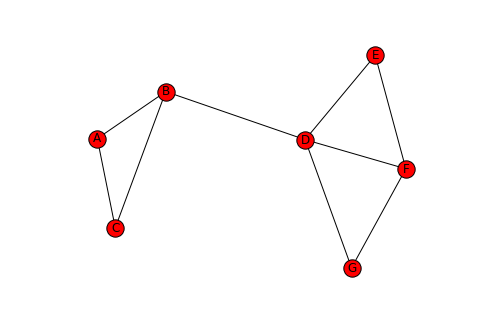

In [40]:
print('second eigen value=%.2f' % eig_vals[1])
print('second eigen vector=\n%s' % eig_vectors[:,1])
nx.draw(graph, with_labels=True)

What do you notice about the second eigenvector?

(Note that first vector component corresponds to node 'A', the second to 'B', etc.)
<br><br><br><br>

We can think of eigenvectors as the cluster assignment to each node.

E.g., nodes with negative values are in cluster 1, nodes with positive values are in cluster 2.

**From eigenvalues to clustering**

Method 1:
- Compute decomposition and examine second eigenvector
- Place nodes of positive values in cluster 1, negative values in cluster 2.

**From eigenvalues to clustering**

Method 2:
- Compute decomposition and examine second eigenvector
- Place nodes of values greather than $\tau$ in cluster 1, and the remainder in cluster 2.
  - The threshold $\tau$ will determine balance of clustering
  - E.g., for $\tau=-.3$?

**Partitioning into more than 2 components?**

- Just recursively repeat the above procedure.


- Or, consider multiple eigen vectors simultaneously.

In [16]:
print('third eigen value=%.2f' % eig_vals[2])
print('third eigen vector=\n%s' % eig_vectors[:,2])

third eigen value=2.00
third eigen vector=
[[  7.61771655e-17]
 [  1.92527950e-16]
 [ -1.92527950e-16]
 [  4.01736195e-17]
 [  7.07106781e-01]
 [  7.02923822e-17]
 [ -7.07106781e-01]]


$\mathbf{v}_1: \{A,B,C\}, \{D,E,F,G\}$

$\mathbf{v}_2: \{A,B,D,E,F\}, \{C,G\}$

In [17]:
print('fourth eigen value=%.2f' % eig_vals[3])
print('fourth eigen vector=\n%s' % eig_vectors[:,3])

fourth eigen value=3.00
fourth eigen vector=
[[ -7.07106781e-01]
 [  1.88737914e-15]
 [  7.07106781e-01]
 [  9.99200722e-16]
 [ -3.88578059e-16]
 [ -3.33066907e-16]
 [ -8.04911693e-16]]


$\mathbf{v}_1: \{A,B,C\}, \{D,E,F,G\}$

$\mathbf{v}_2: \{A,B,C,D,E\}, \{C,G\}$
    
$\mathbf{v}_3: \{A,E,F,G\}, \{B,C,D\}$

Method 3:
- Represent each node by all of its eigenvectors
- Cluster the result using a standard algorithm like $k$-means

In [27]:
# get first row of eigenvector matrix.
eig_vectors[0,:]

matrix([[ -3.77964473e-01,   4.92886500e-01,   7.61771655e-17,
          -7.07106781e-01,  -3.20722630e-01,  -8.40213177e-17,
          -1.06502348e-01]])

In [28]:
# get second row of eigenvector matrix.
eig_vectors[1,:]

matrix([[ -3.77964473e-01,   2.96559521e-01,   1.92527950e-16,
           1.88737914e-15,   7.50451469e-01,   6.04607112e-16,
           4.53891948e-01]])

A 0.492886499631 7.61771654839e-17
B 0.296559521215 1.92527950444e-16
C 0.492886499631 -1.92527950444e-16
D -0.214220281556 4.01736194763e-17
E -0.356037412973 0.707106781187
F -0.356037412973 7.02923822129e-17
G -0.356037412973 -0.707106781187


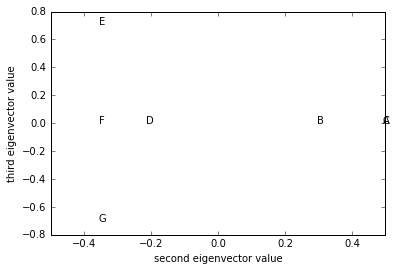

In [41]:
# plot each point using 2nd and 3rd eigen vector
def plot_by_eigenvectors(eig_vectors):
    plt.figure()
    for i, name in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G']):
        v1 = eig_vectors[i, 1]
        v2 = eig_vectors[i, 2]
        plt.annotate(name, xy=(v1, v2))
        print(name, v1, v2)
    plt.xlim(-.5,.5)
    plt.ylim(-.8,.8)
    plt.xlabel('second eigenvector value')
    plt.ylabel('third eigenvector value')
    plt.show()
    
plot_by_eigenvectors(eig_vectors)